# Tutorial for Gromov-Wassserstein unsupervised alignment 

In [15]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../'))

import numpy as np

from src.align_representations import Representation, AlignRepresentations, OptimizationConfig, VisualizationConfig

# Step1: Prepare dissimilarity matrices or embeddings from the data
First, you need to prepare dissimilarity matrices or embeddings from your data.  
To store dissimilarity matrices or embeddings, an instance of the class `Representation` is used.   
Please put your dissimilarity matrices or embeddings into the variables `sim_mat` or `embedding` in this instance.   

## Load data
`AllenBrain`: Neuropixel data recorded in the visual areas of mice from the Allen Brain Observatory

In [16]:
# list of representations where the instances of "Representation" class are included
representations = list()
data_select = "AllenBrain"

### Dataset `AllenBrain`
We treat the average spike count for `natural movie one` in the VISal and VISam of two independent pseudo-mice as an embedding.

In [17]:
representations = []
for name in ["pseudo_a_VISal", "pseudo_b_VISam"]:
    emb = np.load(f"../../data/AllenBrain/{name}.npy")
    representation = Representation(
        name=name,
        embedding=emb,  # the dissimilarity matrix will be computed with this embedding.
        metric="cosine",
        get_embedding=False, # If there is the embeddings, plese set this variable "False".
        object_labels=np.arange(emb.shape[0]) 
    )
    representations.append(representation)

# Step 2: Set the parameters for the optimazation of GWOT
Second, you need to set the parameters for the optimization of GWOT.    
For most of the parameters, you can start with the default values.   
However, there are some essential parameters that you need to check for your original applications.  

## Optimization Config  

#### Most important parameters to check for your application:
`eps_list`: The range of the values of epsilon for entropic GWOT.   
If epsilon is not in appropriate ranges (if it is too low), the optimization may not work properly.   
Although the algorithm will find good epsilon values after many trials, it is a good practice to narrow down the range beforehand.   

`num_trial`: The number of trials to test epsilon values from the specified range.   
This number directly determines the quality of the unsupervised alignment.   
You should set this number high enough to find good local minima. 

In [18]:
eps_list_tutorial = [1e-4, 1e-1]
device = 'cpu'
to_types = 'numpy'
multi_gpu = False

eps_log = True
num_trial = 100
init_mat_plan = "random"

In [19]:
config = OptimizationConfig(    
    eps_list = eps_list_tutorial,
    eps_log = eps_log,
    num_trial = num_trial,
    sinkhorn_method='sinkhorn_log',
    
    ### Set the device ('cuda' or 'cpu') and variable type ('torch' or 'numpy')
    to_types = to_types,
    device = device,
    data_type = "double", 
    
    n_jobs = 1,
    multi_gpu = multi_gpu, 
    db_params={"drivername": "sqlite"},
    
    ### Set the parameters for optimization
    # 'uniform': uniform matrix, 'diag': diagonal matrix', random': random matrix
    init_mat_plan = init_mat_plan,
    
    # user-defined initialization plans
    user_define_init_mat_list = None,

    n_iter = 1,
    max_iter = 500,
    
    sampler_name = 'tpe',
    pruner_name = 'hyperband',
    pruner_params = {
        'n_startup_trials': 1, 
        'n_warmup_steps': 2, 
        'min_resource': 2, 
        'reduction_factor' : 3
    },
)

## Step 3 : Gromov-Wasserstein Optimal Transport (GWOT) between Representations
Third, you perform GWOT between the instanses of "Representation", by using the class `AlignRepresentations`.  
This class has methods for the optimization of entropic Gromov-Wasserstein distance, and the evaluation of the GWOT (Step 4).  
This class also has a method to perform conventional Representation Similarity Analysis (RSA).   

In [20]:
# Create an "AlignRepresentations" instance
align_representation = AlignRepresentations(
    config=config,
    representations_list=representations,   

    # histogram matching : this will adjust the histogram of target to that of source.
    histogram_matching=False,

    # metric : The metric for computing the distance between the embeddings. Please set the metric tha can be used in "scipy.spatical.distance.cdist()".
    metric="cosine", 

    # main_results_dir : folder or file name when saving the result
    main_results_dir = "../../results/" + data_select,
   
    # data_name : Please rewrite this name if users want to use their own data.
    data_name = data_select,
)

data_name : AllenBrain
pairwise_method : combination
All the pairs in the list below will be computed. 
pair: pseudo_a_VISal_vs_pseudo_b_VISam eps_list: [0.0001, 0.1]


## Show dissimilarity matrices

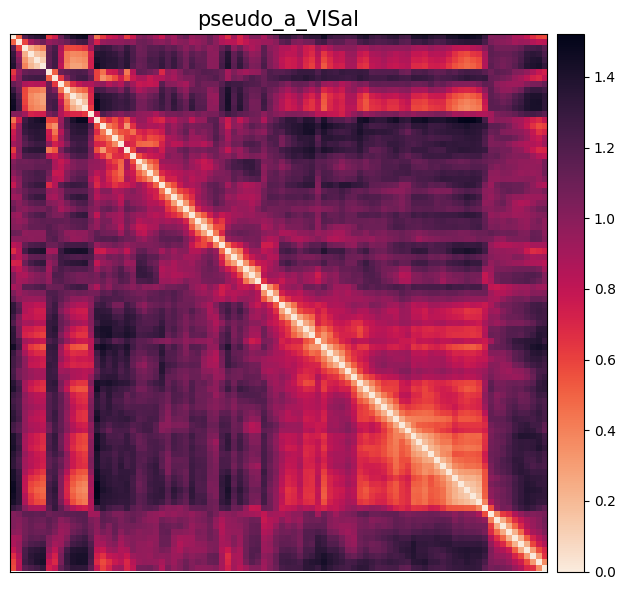

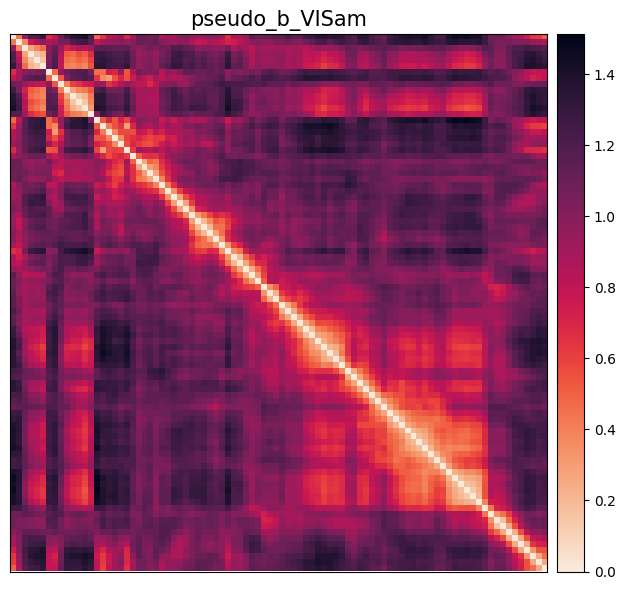

In [21]:
sim_mat_format = "default"

visualize_config = VisualizationConfig(
    figsize=(8, 6),
    title_size = 15, 
    cmap="rocket_r",
)

visualize_hist = VisualizationConfig(figsize=(8, 6), color='C0')

sim_mat = align_representation.show_sim_mat(
    sim_mat_format = sim_mat_format, 
    visualization_config = visualize_config,
    visualization_config_hist = visualize_hist,
    show_distribution=False,
)

## Reperesentation Similarity Aanalysis (RSA)
This performs a conventional representation similarity analysis.

In [22]:
### parameters for computing RSA
# metric = "pearson" or "spearman" by scipy.stats
# The result of RSA for each pair will be stored in align_representation.RSA_corr
align_representation.RSA_get_corr(metric = "pearson")

# print(align_representation.RSA_corr)

Correlation pseudo a VISal vs pseudo b VISam : 0.920548793420427


GWOT is performed by appling the method `gw_alignment` to the instance of `AlignRepresentations` class.

We show all the parameters to run GWOT computation as an example with THINGS or DNN dataset because these dataset have category information label.

For the dataset of color, AllenBrain, and simulation (these doesn’t have the category information), we show how to do this in next cell. 

Here is the example to compute the GWOT for each pair for color, AllenBrain, and simulation datasets below.

In [23]:
# If the computation has been completed and there is no need to recompute, set "compute_OT" to False. In this case, the previously calculated OT plans will be loaded.
compute_OT = True

### If the previous optimization data exists, you can delete it.
# Setting delete_results=True will delete both the database and the directory where the results of the previous optimization are stored.
# The code will prompt for confirmation before deleting all the results.
delete_results = False

fix init mat random seed: False


  0%|          | 0/1 [00:00<?, ?it/s]

/home1/user/ken-takeda/GWTune/.venv/lib/python3.9/site-packages/ot/bregman.py:750: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
[I 2024-10-23 15:44:02,109] Trial 10 finished with value: 0.02215874031668189 and parameters: {'eps': 0.0018817023255908998}. Best is trial 3 with value: 0.017543378517079107.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:44:11,170] Trial 11 finished with value: 0.019740809377441 and parameters: {'eps': 0.0014792967426371314}. Best is trial 3 with value: 0.017543378517079107.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:44:22,166] Trial 12 finished with value: 0.021600593948567184 and parameters: {'eps': 0.0007841351338784148}. Best is trial 3 with value: 0.017543378517079107.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:44:31,251] Trial 13 finished with value: 0.018100703612591848 and parameters: {'eps': 0.0035385000804009246}. Best is trial 3 with value: 0.017543378517079107.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:44:52,163] Trial 14 finished with value: 0.021421521523299798 and parameters: {'eps': 0.004975529116456155}. Best is trial 3 with value: 0.017543378517079107.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:45:00,483] Trial 15 finished with value: 0.021588929608564827 and parameters: {'eps': 0.011769044926591624}. Best is trial 3 with value: 0.017543378517079107.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:45:12,877] Trial 16 finished with value: 0.011117376030562131 and parameters: {'eps': 0.004364249716948715}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:45:14,676] Trial 17 finished with value: 0.05728941658977604 and parameters: {'eps': 0.03185343597577722}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:45:26,926] Trial 18 finished with value: 0.022483556963287608 and parameters: {'eps': 0.007597154083124763}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:45:51,905] Trial 19 finished with value: 0.022609177115257978 and parameters: {'eps': 0.0008110971148045334}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:46:00,925] Trial 20 finished with value: 0.014805121421548904 and parameters: {'eps': 0.0033854983853349742}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:46:25,301] Trial 21 finished with value: 0.020273317159705553 and parameters: {'eps': 0.0027231405200593534}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:46:35,989] Trial 22 finished with value: 0.020383117738603455 and parameters: {'eps': 0.0034150215701571245}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:47:24,087] Trial 23 finished with value: 0.02317325818410035 and parameters: {'eps': 0.00809713716568383}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:47:26,242] Trial 24 finished with value: 0.05544275818718352 and parameters: {'eps': 0.030090692952201292}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:47:31,701] Trial 25 finished with value: 0.034148426954397654 and parameters: {'eps': 0.01996695326157185}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:47:48,147] Trial 26 finished with value: 0.025771175684011237 and parameters: {'eps': 0.0008376500733981644}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:48:02,280] Trial 27 finished with value: 0.023918026097554605 and parameters: {'eps': 0.004502947249586284}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:48:18,129] Trial 28 finished with value: 0.021885786297169432 and parameters: {'eps': 0.0026039510134331662}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:48:51,079] Trial 29 finished with value: 0.019462843476475745 and parameters: {'eps': 0.001896168278558623}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:49:01,560] Trial 30 finished with value: 0.020739300889370656 and parameters: {'eps': 0.009099331358034531}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:49:13,984] Trial 31 finished with value: 0.018530345861465274 and parameters: {'eps': 0.0038312163647116868}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:49:25,057] Trial 32 finished with value: 0.024196797466470656 and parameters: {'eps': 0.0012173017540248804}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:49:40,825] Trial 33 finished with value: 0.022323933149361 and parameters: {'eps': 0.005682843322296768}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:49:51,546] Trial 34 finished with value: 0.021117696467838287 and parameters: {'eps': 0.0034029317928186025}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:49:57,217] Trial 35 finished with value: 0.02991170920412351 and parameters: {'eps': 0.018183320013855038}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:50:02,919] Trial 36 finished with value: 0.023202980152462464 and parameters: {'eps': 0.0004548325994369517}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:50:03,920] Trial 37 finished with value: 0.08821161048575274 and parameters: {'eps': 0.09728583151931058}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:50:11,481] Trial 38 finished with value: 0.024316245567668898 and parameters: {'eps': 0.0021002929671795362}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:50:23,655] Trial 39 finished with value: 0.019420538747508452 and parameters: {'eps': 0.010040072096533233}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:50:32,650] Trial 40 finished with value: 0.015603762652908403 and parameters: {'eps': 0.006083919784324069}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:50:46,718] Trial 41 finished with value: 0.023964887477417627 and parameters: {'eps': 0.005947289399642562}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:51:02,773] Trial 42 finished with value: 0.02380825174544282 and parameters: {'eps': 0.0013106502165413495}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:51:15,183] Trial 43 finished with value: 0.02145274348229215 and parameters: {'eps': 0.004731029630688916}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:51:30,861] Trial 44 finished with value: 0.02886499039747639 and parameters: {'eps': 0.014559698776544817}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:51:43,250] Trial 45 finished with value: 0.012769696384846 and parameters: {'eps': 0.002797544132155217}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:51:50,557] Trial 46 finished with value: 0.025009299129475998 and parameters: {'eps': 0.0024777928457205447}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:52:15,030] Trial 47 finished with value: 0.02289023702829988 and parameters: {'eps': 0.006336190018107408}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:52:25,198] Trial 48 finished with value: 0.020633823398839776 and parameters: {'eps': 0.011033875084193526}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:52:42,139] Trial 49 finished with value: 0.02401284584650971 and parameters: {'eps': 0.0010209658777979586}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:52:51,253] Trial 50 finished with value: 0.022064328367363294 and parameters: {'eps': 0.0016045673237559453}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:53:07,186] Trial 51 finished with value: 0.020724269831083643 and parameters: {'eps': 0.003965958311301128}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:53:17,916] Trial 52 finished with value: 0.02115674694881913 and parameters: {'eps': 0.002857133863540302}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:53:28,503] Trial 53 finished with value: 0.0160855774601165 and parameters: {'eps': 0.007737864789719576}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:53:44,239] Trial 54 finished with value: 0.018553383708962295 and parameters: {'eps': 0.007611526604303546}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:53:47,748] Trial 55 finished with value: 0.044638751721712784 and parameters: {'eps': 0.02431415747070254}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:54:27,315] Trial 56 finished with value: 0.024315172863212716 and parameters: {'eps': 0.006993731874575465}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:54:44,855] Trial 57 finished with value: 0.01758282721105154 and parameters: {'eps': 0.004481290687854007}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:54:48,579] Trial 58 finished with value: 0.023510563382027432 and parameters: {'eps': 0.00010788661515919518}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:54:58,579] Trial 59 finished with value: 0.020204312152669886 and parameters: {'eps': 0.012844448141107466}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:55:19,532] Trial 60 finished with value: 0.01960289771351193 and parameters: {'eps': 0.0020954587341738473}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:55:31,849] Trial 61 finished with value: 0.023379504402776127 and parameters: {'eps': 0.005321404698713076}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:55:42,563] Trial 62 finished with value: 0.017358571881760973 and parameters: {'eps': 0.004607970668121419}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:56:44,306] Trial 63 finished with value: 0.023092803685856467 and parameters: {'eps': 0.008999571819298188}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:57:15,424] Trial 64 finished with value: 0.021009120767180478 and parameters: {'eps': 0.0031722934760976653}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:57:29,483] Trial 65 finished with value: 0.01859954305149841 and parameters: {'eps': 0.004136293442476531}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:57:43,580] Trial 66 finished with value: 0.024002025988188097 and parameters: {'eps': 0.002294081882608088}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:57:50,860] Trial 67 finished with value: 0.02260956745566587 and parameters: {'eps': 0.0016066625809182022}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:58:05,015] Trial 68 finished with value: 0.013006102310763757 and parameters: {'eps': 0.006800238189119683}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:58:49,662] Trial 69 finished with value: 0.021890723364749988 and parameters: {'eps': 0.00712524125460484}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:59:05,434] Trial 70 finished with value: 0.021274601658418515 and parameters: {'eps': 0.005464010310430641}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:59:12,857] Trial 71 finished with value: 0.014425150785959413 and parameters: {'eps': 0.003043303212466394}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:59:23,513] Trial 72 finished with value: 0.01869251935739724 and parameters: {'eps': 0.0031697385852269043}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 15:59:44,436] Trial 73 finished with value: 0.019775616197311684 and parameters: {'eps': 0.003647951804337501}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:00:11,856] Trial 74 finished with value: 0.024884534136658643 and parameters: {'eps': 0.008717953237234836}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:00:22,550] Trial 75 finished with value: 0.01373852378814322 and parameters: {'eps': 0.0027541637423082674}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:00:57,118] Trial 76 finished with value: 0.016652936079178567 and parameters: {'eps': 0.002769144526402425}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:01:06,253] Trial 77 finished with value: 0.023139252589640027 and parameters: {'eps': 0.001759441760267911}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:01:07,134] Trial 78 finished with value: 0.06881407064186265 and parameters: {'eps': 0.0519401193527015}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:01:21,812] Trial 79 finished with value: 0.02406724630946331 and parameters: {'eps': 0.0011366424004105452}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:02:09,283] Trial 80 finished with value: 0.02737409864944021 and parameters: {'eps': 0.011615021875405852}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:02:21,666] Trial 81 finished with value: 0.01848827678073811 and parameters: {'eps': 0.0027377540642985576}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:02:32,393] Trial 82 finished with value: 0.01928784908832567 and parameters: {'eps': 0.0023756303048596394}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:02:48,233] Trial 83 finished with value: 0.02099144253191746 and parameters: {'eps': 0.00313622561238439}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:03:14,327] Trial 84 finished with value: 0.020441285632766905 and parameters: {'eps': 0.005924895653827319}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:03:19,985] Trial 85 finished with value: 0.02380858411165657 and parameters: {'eps': 0.0019816021759628084}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:03:32,718] Trial 86 finished with value: 0.024220412501377166 and parameters: {'eps': 0.0005423149812545882}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:03:40,161] Trial 87 finished with value: 0.031073911295671088 and parameters: {'eps': 0.017314698333193983}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:03:52,582] Trial 88 finished with value: 0.013865396353642619 and parameters: {'eps': 0.003684679815938829}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:04:03,266] Trial 89 finished with value: 0.014628838703431842 and parameters: {'eps': 0.004935714159294568}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:04:15,682] Trial 90 finished with value: 0.016855763793460782 and parameters: {'eps': 0.00437264548985884}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:04:45,209] Trial 91 finished with value: 0.017825504301619263 and parameters: {'eps': 0.0036435546863200375}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:05:05,939] Trial 92 finished with value: 0.01701701307100808 and parameters: {'eps': 0.007810590531664973}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:05:18,277] Trial 93 finished with value: 0.017342012871012627 and parameters: {'eps': 0.005057122242182144}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:05:30,314] Trial 94 finished with value: 0.01940741894864844 and parameters: {'eps': 0.010028909481598899}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:05:39,375] Trial 95 finished with value: 0.019108686788002927 and parameters: {'eps': 0.003981195912097983}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:05:44,972] Trial 96 finished with value: 0.014815048006847256 and parameters: {'eps': 0.006539411229974154}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:05:57,399] Trial 97 finished with value: 0.015507639994128235 and parameters: {'eps': 0.0060461488126210975}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:06:23,631] Trial 98 finished with value: 0.021760074224736036 and parameters: {'eps': 0.005084759657345992}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:06:39,393] Trial 99 finished with value: 0.01775447608552625 and parameters: {'eps': 0.006362291865345109}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:06:46,739] Trial 100 finished with value: 0.02002615539395327 and parameters: {'eps': 0.002981040028616244}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:06:53,990] Trial 101 finished with value: 0.01279945899906104 and parameters: {'eps': 0.006566120944672372}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:07:06,557] Trial 102 finished with value: 0.023329457452872356 and parameters: {'eps': 0.003595505947233263}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:07:25,713] Trial 103 finished with value: 0.021294833466714666 and parameters: {'eps': 0.0065713406468589294}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:07:41,562] Trial 104 finished with value: 0.0151778847664378 and parameters: {'eps': 0.0022277703284864963}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:08:02,458] Trial 105 finished with value: 0.02021029646142495 and parameters: {'eps': 0.0024030023686732018}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:08:11,482] Trial 106 finished with value: 0.019861864118291144 and parameters: {'eps': 0.0017192904923640244}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:08:32,398] Trial 107 finished with value: 0.021325325827598336 and parameters: {'eps': 0.0042733385324058805}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:08:41,476] Trial 108 finished with value: 0.021793350306191346 and parameters: {'eps': 0.0014717875120320622}. Best is trial 16 with value: 0.011117376030562131.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2024-10-23 16:08:57,289] Trial 109 finished with value: 0.02413130180414171 and parameters: {'eps': 0.0022949191538011084}. Best is trial 16 with value: 0.011117376030562131.


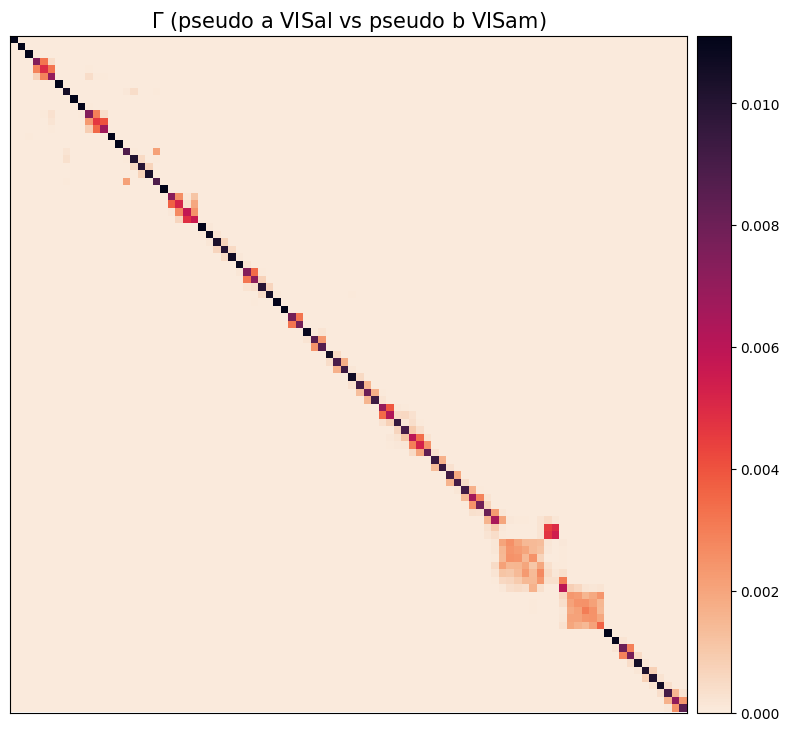

In [24]:
sim_mat_format = "default"

visualize_config = VisualizationConfig(
    show_figure=True,
    figsize=(8, 8), 
    title_size = 15, 
    cmap="rocket_r",
)

align_representation.gw_alignment(
    compute_OT = compute_OT,
    delete_results = delete_results,
    return_data = False,
    return_figure = True,
    OT_format = sim_mat_format,
    visualization_config = visualize_config,
)

# Step 4: Evaluation and Visualization
Finally, you can evaluate and visualize the unsupervise alignment of GWOT.   

## Show how the GWD was optimized
`show_optimization_log` will make two figures to show both the relationships between epsilons (x-axis) and GWD (y-axis), and between accuracy (x-axis) and GWD (y-axis).



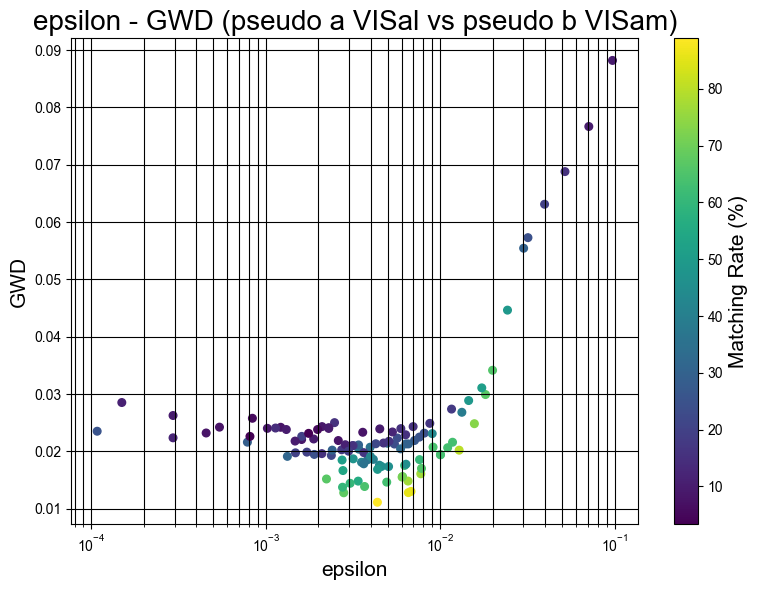

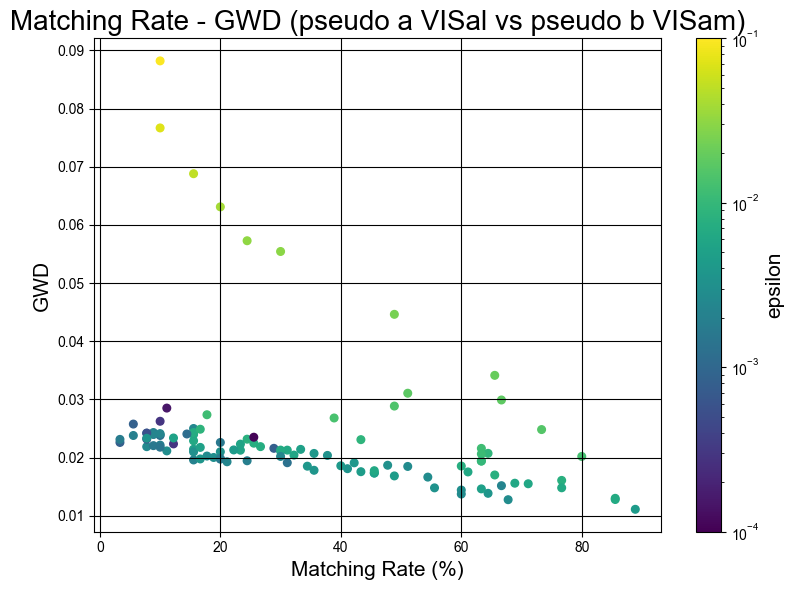

In [25]:
### Show how the GWD was optimized (evaluation figure)
# show both the relationships between epsilons and GWD, and between accuracy and GWD

visualize_config = VisualizationConfig(
    show_figure = True,
    fig_ext='svg',
    font='Arial',
    cmap = 'viridis',
    
    plot_eps_log = eps_log,
)


align_representation.show_optimization_log(fig_dir=None, visualization_config=visualize_config) 

## Evaluation of the accuracy of the unsupervised alignment
There are two ways to evaluate the accuracy.  
1. Calculate the accuracy based on the OT plan. 
- For using this method, please set the parameter `eval_type = "ot_plan"` in "calc_accuracy()".
  
2. Calculate the matching rate based on the k-nearest neighbors of the embeddings.
-  For using this method, please set the parameter `eval_type = "k_nearest"` in "calc_accuracy()".

For both cases, the accuracy evaluation criterion can be adjusted by considering "top k".  
By setting "top_k_list", you can observe how the accuracy increases as the criterion is relaxed.

Top k accuracy : 
        pseudo_a_VISal_vs_pseudo_b_VISam
top_n                                  
1                             88.888889
5                             95.555556
10                           100.000000

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


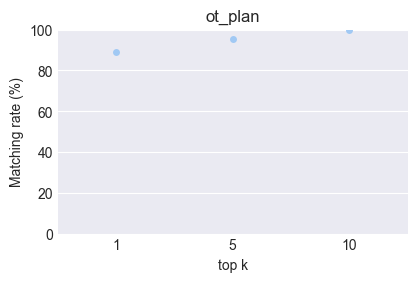

In [26]:
## Calculate the accuracy based on the OT plan. 
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "ot_plan")
align_representation.plot_accuracy(eval_type = "ot_plan", scatter = True)

top_k_accuracy = align_representation.top_k_accuracy # you can get the dataframe directly 

K nearest matching rate : 
        pseudo_a_VISal_vs_pseudo_b_VISam
top_n                                  
1                             93.333333
5                             97.777778
10                           100.000000

Mean : 
 top_n
1    NaN
5    NaN
10   NaN
dtype: float64


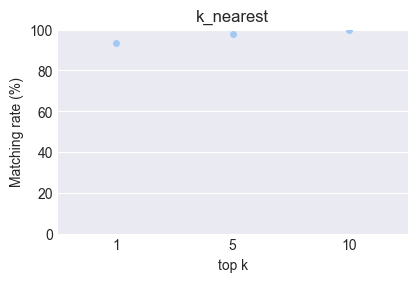

In [27]:
## Calculate the matching rate based on the k-nearest neighbors of the embeddings.
align_representation.calc_accuracy(top_k_list = [1, 5, 10], eval_type = "k_nearest")
align_representation.plot_accuracy(eval_type = "k_nearest", scatter = True)

k_nearest_matching_rate = align_representation.k_nearest_matching_rate # you can get the dataframe directly 

## Procrustes Analysis
Using optimized transportation plans, you can align the embeddings of each representation to a shared space in an unsupervised manner.  
The `"pivot"` refers to the target embeddings space to which the other embeddings will be aligned.   
You have the option to designate the `"pivot"` as one of the representations or the barycenter.  
Please ensure that 'pair_number_list' includes all pairs between the pivot and the other Representations.  

If you wish to utilize the barycenter, please make use of the method `AlignRepresentation.barycenter_alignment()`.  
You can use it in the same manner as you did with `AlignRepresentation.gw_alignment()`.

No category information is given.


/home1/user/ken-takeda/GWTune/src/utils/visualize_functions.py:454: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


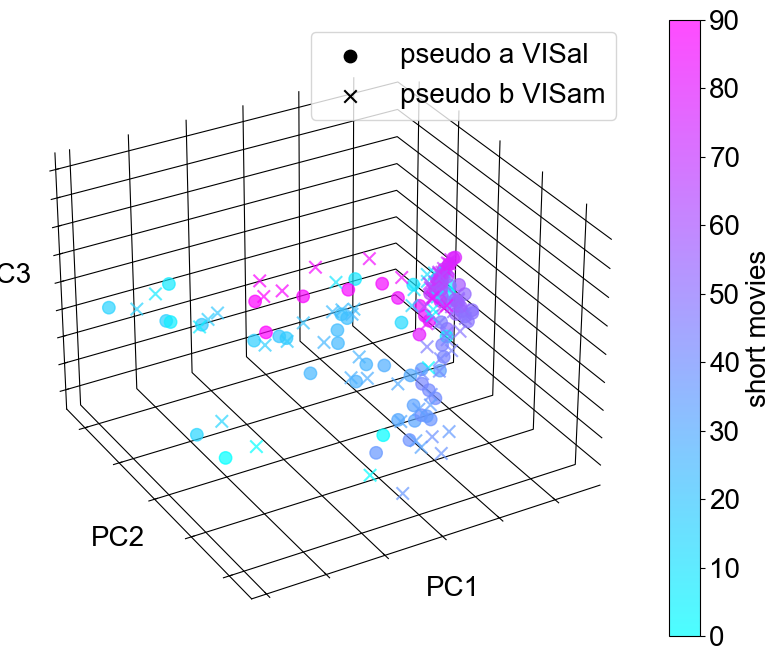

In [28]:
emb_name = "PCA" #"TSNE", "PCA", "MDS"

visualization_embedding = VisualizationConfig(
    fig_ext="svg",
    figsize=(10, 10),
    marker_size=80,
    xlabel="PC1",
    ylabel="PC2",
    zlabel="PC3",
    legend_size=20,
    font="Arial",
    color_hue="cool",
    cmap="cool",
    colorbar_label="short movies",
    colorbar_range=[0, len(emb)],
    colorbar_shrink=0.8,
    xlabel_size=20,
    ylabel_size=20,
    zlabel_size=20,
    alpha=0.7,
)

align_representation.visualize_embedding(
    dim=3, # the dimensionality of the space the points are embedded in. You can choose either 2 or 3.
    pivot=0, # the number of one of the representations or the "barycenter".
    method="PCA",
    visualization_config=visualization_embedding,
)